In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import json
import time
import os
import tensorflow as tf
import tensorflow_probability as tfp
import pickle
import string

from tensorflow.keras.utils import to_categorical

tfd = tfp.distributions

InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

# Read and write data json files

In [3]:
train_files = !cd femnist_data/large_dataset/train; ls
test_files = !cd femnist_data/large_dataset/test; ls

train_data_list = []
for file in train_files:
    with open('femnist_data/large_dataset/train/'+file) as f:
        train_data_list.append(json.load(f))
        
test_data_list = []
for file in test_files:
    with open('femnist_data/large_dataset/test/'+file) as f:
        test_data_list.append(json.load(f))

In [126]:
train_data_list[0].keys()

dict_keys(['users', 'num_samples', 'user_data'])

35 different data files, unclear why

5 or 6 users in each file, unclear why, 190 total 

100s of data points for each user

784 pixels



In [4]:
# Training set
users_train = []
all_train_x = []
all_train_y = []
for data_dict in train_data_list:
    for user, xy_dict in data_dict['user_data'].items():
        for i in range(len(xy_dict['x'])):
            users_train.append(user)
            all_train_x.append(xy_dict['x'][i])
            all_train_y.append(xy_dict['y'][i])
            
# Test set
users_test = []
all_test_x = []
all_test_y = []
for data_dict in test_data_list:
    for user, xy_dict in data_dict['user_data'].items():
        for i in range(len(xy_dict['x'])):
            users_test.append(user)
            all_test_x.append(xy_dict['x'][i])
            all_test_y.append(xy_dict['y'][i])
            

In [7]:
x_train = np.stack(all_train_x).astype(np.float32)
y_train = to_categorical(np.array(all_train_y))
x_test = np.stack(all_test_x).astype(np.float32)
y_test = to_categorical(np.array(all_test_y))


user2id_dict = pd.concat([
    pd.Series(users_train),
           pd.Series(users_train).astype('category').cat.codes], axis=1).drop_duplicates().set_index(0).to_dict()[1]

users_train_id = np.array(list(map(lambda x: user2id_dict[x], users_train)))
users_test_id = np.array(list(map(lambda x: user2id_dict[x], users_test)))

In [128]:
np.unique(users_train_id)[:1]

array([0])

In [9]:
x_test.shape

(80749, 784)

In [10]:
users_train_id

array([3394, 3394, 3394, ...,  123,  123,  123])

In [130]:
# partitioned_data_dict = {
#     uid: [
#         arr[np.where(arr == uid)[0]] 
#         for arr 
#         in [x_train, y_train, x_test, y_test]
#     ]
#     for uid 
#     in np.unique(users_train_id)
# }

In [11]:
np.save('femnist_data/large_dataset/x_train.npy', x_train)
np.save('femnist_data/large_dataset/y_train.npy', y_train)
np.save('femnist_data/large_dataset/x_test.npy', x_test)
np.save('femnist_data/large_dataset/y_test.npy', y_test)
np.save('femnist_data/large_dataset/gid_train.npy', users_train_id)
np.save('femnist_data/large_dataset/gid_test.npy', users_test_id )

In [3]:
x_train = np.load('femnist_data/large_dataset/x_train.npy', )
y_train = np.load('femnist_data/large_dataset/y_train.npy', )
x_test = np.load('femnist_data/large_dataset/x_test.npy', )
y_test = np.load('femnist_data/large_dataset/y_test.npy', )
users_train_id = np.load('femnist_data/large_dataset/gid_train.npy', )
users_test_id = np.load('femnist_data/large_dataset/gid_test.npy',  )

In [4]:
import string
labels = list(string.digits +  string.ascii_uppercase + string.ascii_lowercase)

In [5]:
gid_train = users_train_id

In [6]:
writer_df = pd.DataFrame(np.stack([y_train.argmax(axis=1), gid_train]).T, columns=['label', 'writer'])

In [7]:
distribution_of_labels = writer_df.groupby('writer')['label'].value_counts().unstack().fillna(0)
distribution_of_labels.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,3500.0,10.103429,2.122335,0.0,9.0,10.0,12.0,17.0
1,3500.0,11.196286,2.101059,0.0,10.0,11.0,12.0,26.0
2,3500.0,10.053714,2.244418,0.0,9.0,10.0,12.0,15.0
3,3500.0,10.310571,2.158708,0.0,9.0,11.0,12.0,14.0
4,3500.0,9.805143,2.372626,0.0,9.0,10.0,11.0,15.0


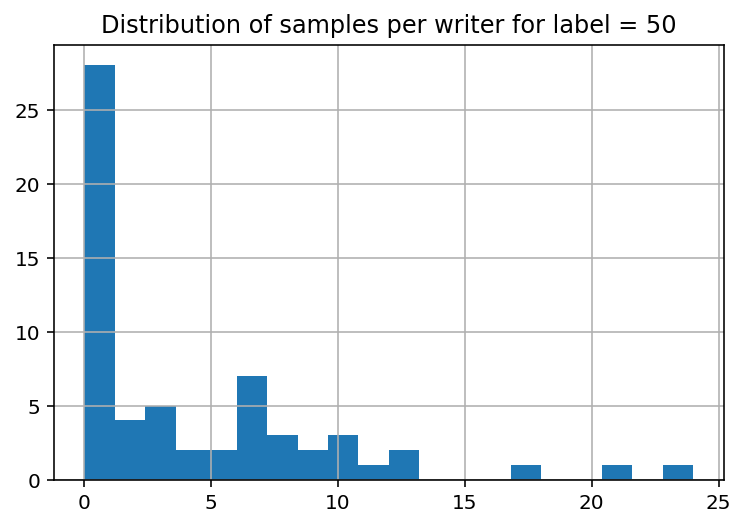

In [8]:
label=50
distribution_of_labels.loc[label].hist(bins=20)
plt.title(f'Distribution of samples per writer for label = {label}');

In [9]:
digit_count = distribution_of_labels.iloc[:,:10].sum(axis=1)
letter_count = distribution_of_labels.iloc[:,10:].sum(axis=1)

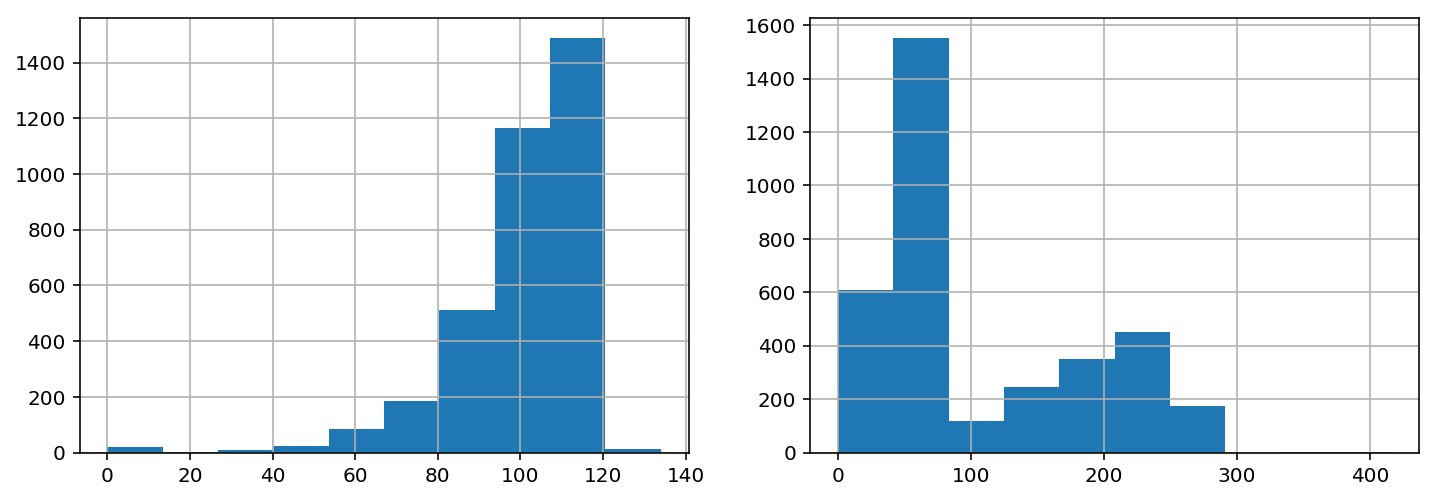

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(121)
digit_count.hist()
plt.subplot(122)
letter_count.hist();

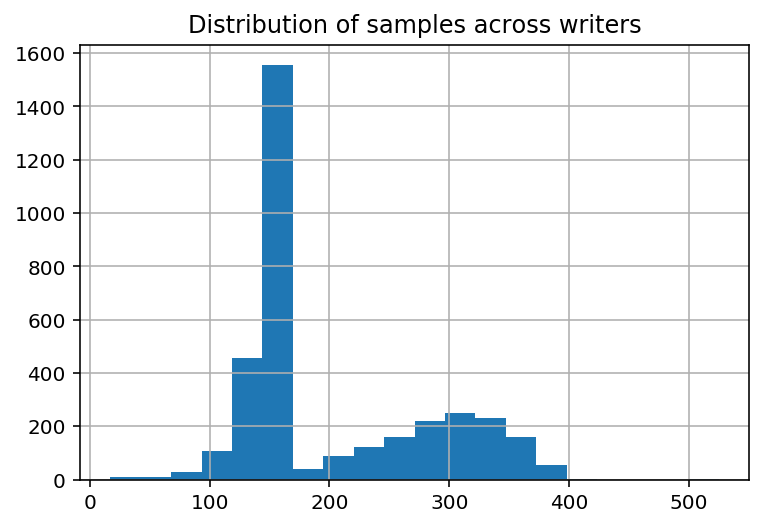

In [11]:
writer_samples_count = writer_df.groupby('writer').size().rename('count')
writer_samples_count.hist(bins=20)
plt.title('Distribution of samples across writers');

In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering

In [13]:
tsne = TSNE(random_state=7, perplexity=100)
proj = tsne.fit_transform(distribution_of_labels)

In [14]:
kmeans = KMeans(n_clusters=2, random_state=10)
cluster_assign = kmeans.fit_predict(proj)

In [15]:
cluster_assign

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

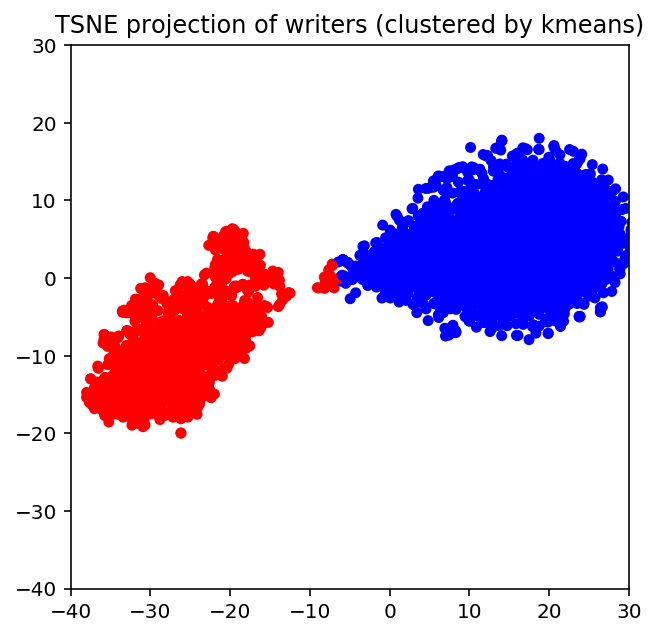

In [16]:
plt.figure(figsize=(5,5))
plt.scatter(proj[:,0], proj[:,1], c=cluster_assign, cmap='bwr', s=20)
plt.title('TSNE projection of writers (clustered by kmeans)')
plt.xlim(-40,30)
plt.ylim(-40,30);

Hmmm clearly seems to be two classes of writers 

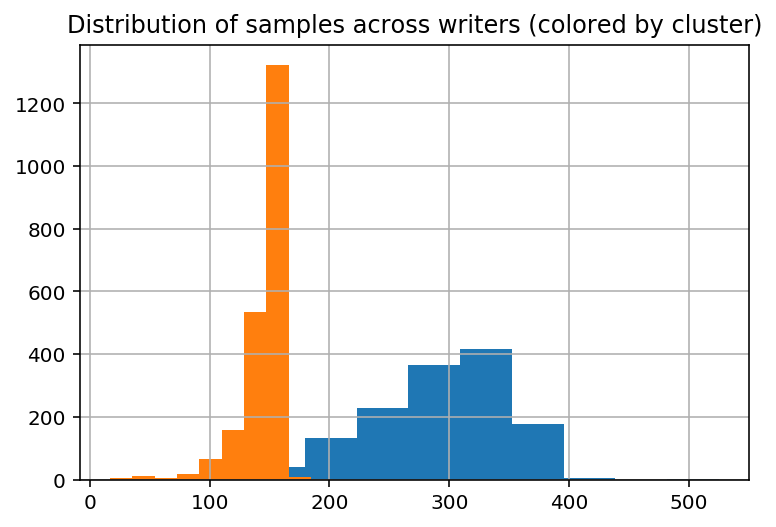

In [17]:
temp = pd.concat([
    pd.Series(cluster_assign),
    distribution_of_labels.sum(axis=1),], 
    axis=1)

plt.hist(temp[temp[0] == 1][1])
plt.hist(temp[temp[0] == 0][1])
plt.grid()
plt.title('Distribution of samples across writers (colored by cluster)');

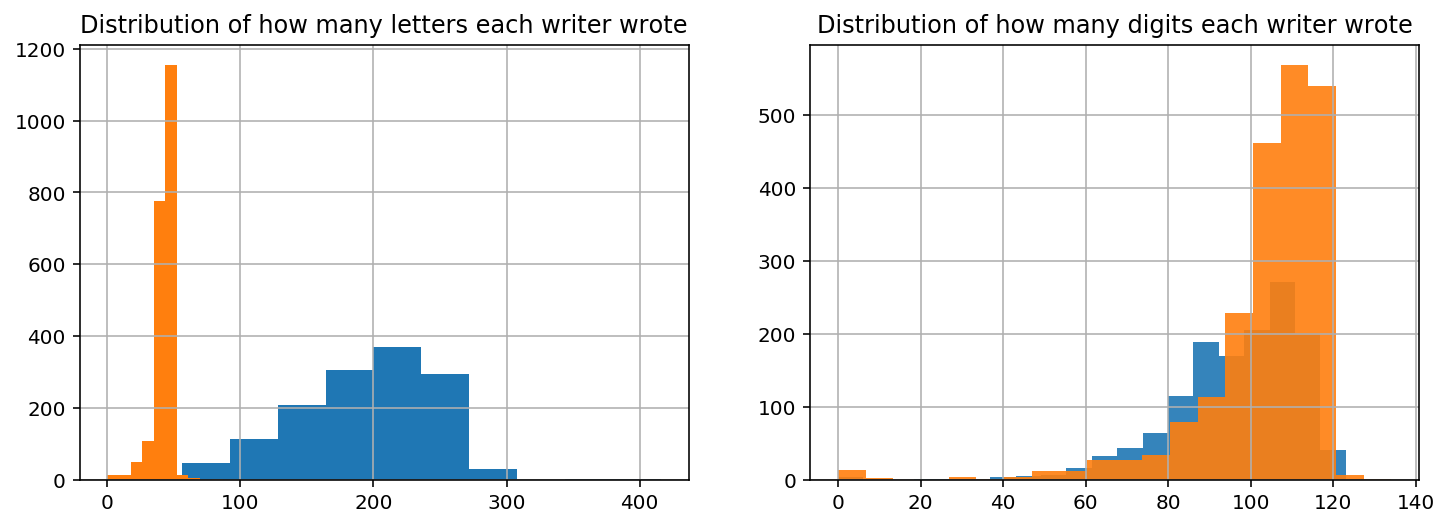

In [18]:
plt.figure(figsize=(12,4))

temp = pd.concat([
    pd.Series(cluster_assign),
    letter_count,], 
    axis=1)

plt.subplot(121)
plt.hist(temp[temp[0] == 1][1])
plt.hist(temp[temp[0] == 0][1])
plt.grid()
plt.title('Distribution of how many letters each writer wrote');

temp = pd.concat([
    pd.Series(cluster_assign),
    digit_count,], 
    axis=1)

plt.subplot(122)
plt.hist(temp[temp[0] == 1][1],alpha=0.9, bins=20)
plt.hist(temp[temp[0] == 0][1], alpha=0.9, bins=20)
plt.grid()
plt.title('Distribution of how many digits each writer wrote');

So it seems like group 1 (blue) has the highest number of samples because they wrote a lot of letters. They also wrote a comparable number of digits as group 0.

So it seems like group 0 (orange) mostly just wrote digits, usually just writing each letter just once.

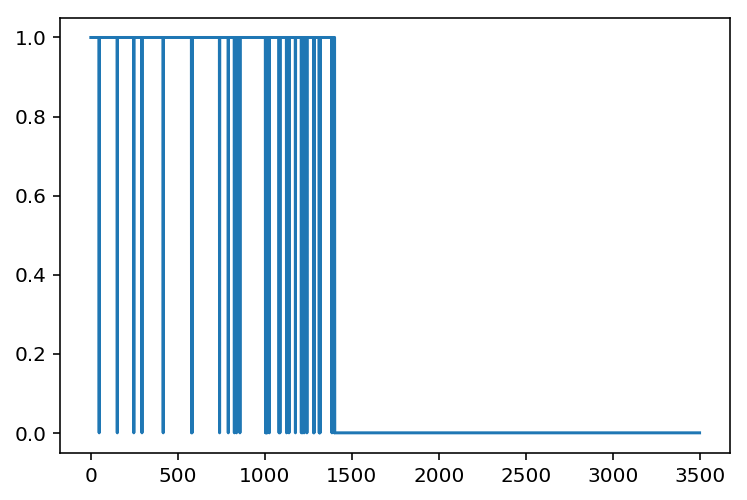

In [35]:
plt.plot(cluster_assign)